## Nea ancestry vs distance to selected regions

In [5]:
suppressPackageStartupMessages({

library(slimr)
library(tidyverse)
library(GenomicRanges)

})

Load the table of coordinates (real and SLiM-based) of functional regions:

In [6]:
region <- "exon"

In [7]:
regions <- read_coordinates(paste0("../data/slim_coords/", region, "_regions.bed"))

In [8]:
trans_regions <- transpose_coordinates(regions, regions)

Load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions):

In [9]:
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

In [10]:
gens <- c(10, 20, 50, 100, seq(200, 1000, 200), seq(1200, 2200, 200))

In [11]:
n_bins <- 5

In [18]:
binned_chroms <- mclapply(1:20, mc.cores = 20, function(rep) {
    
map_dfr(gens, function(gen) {

    vcf <- read_vcf(paste0("../data/simulations/delta_constant_", region, "_h_0.5_rep_", rep, "_gen_", gen, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% trans_regions]
    outside_markers <- trans_markers[! trans_markers %within% trans_regions]

    hap_ids <- colnames(mcols(inside_markers)) %>% keep(~ str_detect(.x, "chr"))

    distance_hits <- distanceToNearest(outside_markers, trans_regions, ignore.strand = TRUE)
    qs <- quantile(mcols(distance_hits)$distance, probs = seq(0, 1, 1 / n_bins))

    outside_dist <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(distance = mcols(distance_hits)$distance,
               dist_bin = as.integer(cut(distance, breaks = qs, labels = 1:n_bins, include.lowest = TRUE))) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, dist_bin, starts_with("chr"))

    inside_dist <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(dist_bin = 0) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, dist_bin, starts_with("chr"))
    
    bind_rows(outside_dist, inside_dist)

})

}) %>% bind_rows

In [19]:
bin_props <- group_by(binned_chroms, dist_bin, gen) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -dist_bin, -gen) %>%
    ungroup %>% 
    mutate(dist_bin = factor(dist_bin))

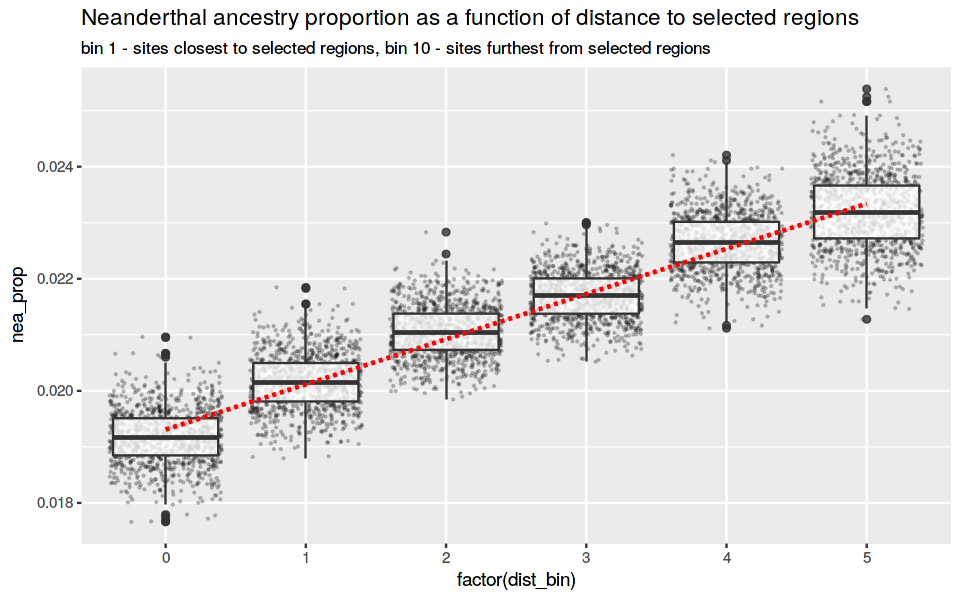

In [20]:
options(repr.plot.width = 8, repr.plot.height = 5)

bin_props %>% filter(gen == 2200) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

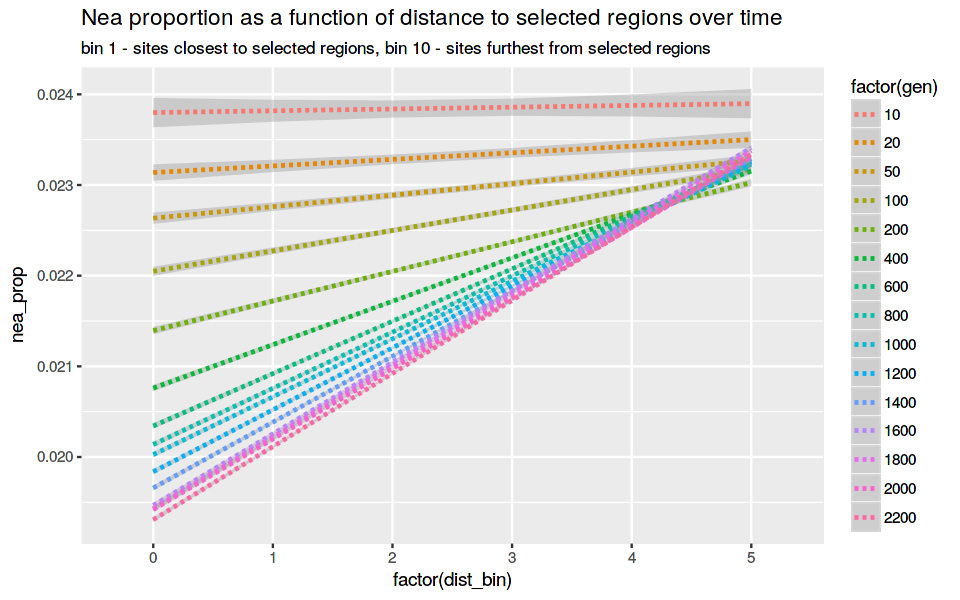

In [21]:
options(repr.plot.width = 8, repr.plot.height = 5)

bin_props %>%
    ggplot(aes(factor(dist_bin), nea_prop, color = factor(gen), group = factor(gen))) +
        geom_smooth(method = "lm", linetype = 2) +
        ggtitle("Nea proportion as a function of distance to selected regions over time",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

In [22]:
saveRDS(bin_props, "../paper/rds/depletion_near_genes.rds")